In [2]:
%%capture
!pip install tensorflow
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install Image
!pip install git+https://github.com/tensorflow/docs

In [3]:
%%capture

from IPython.display import display

import glob
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import random
import math
import tensorflow_docs.vis.embed as embed


2021-12-13 09:22:08.521354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 09:22:08.521371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Global Settings

In [4]:
image_height = 448
image_width = 256
batch_size = 16

# Loss Visualization
VIS_Y_LOWER_LIMIT = 0.0
VIS_Y_UPPER_LIMIT = 1.0
VIS_OUTPUT_PATH = "output/vis/"
VIS_IMAGE_SIZE = (image_height, image_width)

# Training
TRAIN = False
EPOCHS = 30

## Preprocessing

In [5]:
# return list containing all directories in given file content
def make_dataset(data_path, list_file):
    raw_im_list = open(os.path.join(data_path, list_file)).read().splitlines()
    # the last line is invalid in test set.
    # print("The last sample is : " + raw_im_list[-1])
    raw_im_list = raw_im_list[:-1]
    assert len(raw_im_list) > 0
    random.shuffle(raw_im_list)

    return  raw_im_list

# transforms given tensor to a PIL Image
def tensor_to_image(tensor):
    tensor *= 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# function to map one directory to the 3 containing images
def _parse_function(folder, scale_rgb=False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale= 1./255)
    prefix = './data/vimeo_triplet/sequences/' + folder
    images = []
    i = 0
    for i in range(1, 4):
        img_path = prefix + '/im' + str(i) + '.png'
        image = tf.io.read_file(img_path)
        image = tf.io.decode_png(image, channels=3, dtype=tf.uint8)
        image = normalization_layer(image)
        images.append(image)
        
    input = tf.concat((images[0], images[2]), axis=2)    
        
    return input, images[1]

'''
# stack first and last frame as one input
def prepare_input_data(triplet):
    im1 = triplet[0]    
    im2 = triplet[1]
    im3 = triplet[2]

    input = tf.concat((im1, im3), axis=2)
    return input, im2
'''    


'\n# stack first and last frame as one input\ndef prepare_input_data(triplet):\n    im1 = triplet[0]    \n    im2 = triplet[1]\n    im3 = triplet[2]\n\n    input = tf.concat((im1, im3), axis=2)\n    return input, im2\n'

In [6]:
# train_list: contains all directory names for training 
# test_list: contains all directory names for testing
train_list = make_dataset('./data/vimeo_triplet/', 'tri_trainlist.txt')
test_list = make_dataset('./data/vimeo_triplet/', 'tri_testlist.txt')

train_dirs = tf.constant(train_list)
test_dirs = tf.constant(test_list)

# create initial dataset with directory names as elements
train_dataset = tf.data.Dataset.from_tensor_slices((train_dirs))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dirs))


# map each directory name to the 3 containing images
train_dataset = train_dataset.map(_parse_function)
test_dataset = test_dataset.map(_parse_function)

# set batch size
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Zum Ausprobieren / Testen
preview = False
if preview:
    for x in train_dataset:
        print(x)
        print(type(train_dataset))


        
        # split input back to separate images
      #  input_list = tf.split(input, 2, axis=2)

      #  tensor_to_image(input_list[0]).show()
 #       tensor_to_image(input_list[1]).show()
#        tensor_to_image(expected).show()

        break
        

2021-12-13 09:22:09.426822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 09:22:09.427431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 09:22:09.427483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-13 09:22:09.427529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-13 09:22:09.427574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## Model

In [7]:
def model():
    Input_1 = tf.keras.layers.Input(shape=(image_width, image_height, 6), name="Input_1")
    
    # Block 1
    Conv1_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv1_1")(Input_1)
    lrelu1_1 = tf.keras.layers.LeakyReLU()(Conv1_1)
    Conv1_2 =  tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv1_2")(lrelu1_1)
    lrelu1_2 = tf.keras.layers.LeakyReLU()(Conv1_2)
    Conv1_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv1_3")(lrelu1_2)
    lrelu1_3 = tf.keras.layers.LeakyReLU()(Conv1_3)
    Pool1 = tf.keras.layers.MaxPooling2D(name="MaxPooling2D_1")(lrelu1_3)
    
    # Block 2
    Conv2_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv2_1")(Pool1)
    lrelu2_1 = tf.keras.layers.LeakyReLU()(Conv2_1)
    Conv2_2 =  tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv2_2")(lrelu2_1)
    lrelu2_2 = tf.keras.layers.LeakyReLU()(Conv2_2)
    Conv2_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1), padding="same", name="conv2_3")(lrelu2_2)
    lrelu2_3 = tf.keras.layers.LeakyReLU()(Conv2_3)
    Pool2 = tf.keras.layers.MaxPooling2D(name="MaxPooling2D_2")(lrelu2_3)
    
    #Block 3
    Conv3_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv3_1")(Pool2)
    lrelu3_1 = tf.keras.layers.LeakyReLU()(Conv3_1)
    Conv3_2 =  tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv3_2")(lrelu3_1)
    lrelu3_2 = tf.keras.layers.LeakyReLU()(Conv3_2)
    Conv3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv3_3")(lrelu3_2)
    lrelu3_3 = tf.keras.layers.LeakyReLU()(Conv3_3)
    Pool3 = tf.keras.layers.MaxPooling2D(name="MaxPooling2D_3")(lrelu3_3)
    
    #Block 4
    Conv4_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv4_1")(Pool3)
    lrelu4_1 = tf.keras.layers.LeakyReLU()(Conv4_1)
    Conv4_2 =  tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv4_2")(lrelu4_1)
    lrelu4_2 = tf.keras.layers.LeakyReLU()(Conv4_2)
    Conv4_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv4_3")(lrelu4_2)
    lrelu4_3 = tf.keras.layers.LeakyReLU()(Conv4_3)
    Pool4 = tf.keras.layers.MaxPooling2D(name="MaxPooling2D_4")(lrelu4_3)
    
    #Block 5
    Conv5_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv5_1")(Pool4)
    lrelu5_1 = tf.keras.layers.LeakyReLU()(Conv5_1)
    Conv5_2 =  tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv5_2")(lrelu5_1)
    lrelu5_2 = tf.keras.layers.LeakyReLU()(Conv5_2)
    Conv5_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", name="conv5_3")(lrelu5_2)
    lrelu5_3 = tf.keras.layers.LeakyReLU()(Conv5_3)
    Pool5 = tf.keras.layers.MaxPooling2D(name="MaxPooling2D_5")(lrelu5_3)
   
    # DConv Block no.5
    DConv5_1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4 ,padding="same", strides=(2,2), name="DConv5_1")(Pool5)
    dconv_lrelu_5_1 = tf.keras.layers.LeakyReLU()(DConv5_1)
    DConv5_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv5_2")(dconv_lrelu_5_1)
    dconv_lrelu_5_2 = tf.keras.layers.LeakyReLU()(DConv5_2)
    DConv5_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv5_3")(dconv_lrelu_5_2)
    dconv_lrelu_5_3 = tf.keras.layers.LeakyReLU()(DConv5_3)
    
    # Merge for DConv Block 4
    merge_4_4 = tf.keras.layers.Concatenate()([Pool4 , dconv_lrelu_5_3])
    # DConv Block no.4
    DConv4_1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4 ,padding="same", strides=(2,2), name="DConv4_1")(merge_4_4)
    dconv_lrelu_4_1 = tf.keras.layers.LeakyReLU()(DConv4_1)
    DConv4_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv4_2")(dconv_lrelu_4_1)
    dconv_lrelu_4_2 = tf.keras.layers.LeakyReLU()(DConv4_2)
    DConv4_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv4_3")(dconv_lrelu_4_2)
    dconv_lrelu_4_3 = tf.keras.layers.LeakyReLU()(DConv4_3)
    
    # Merge for DConv Block 3
    merge_3_3 = tf.keras.layers.Concatenate()([Pool3, dconv_lrelu_4_3])
    # DConv Block no.3
    DConv3_1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4 ,padding="same", strides=(2,2), name="DConv3_1")(merge_3_3)
    dconv_lrelu_3_1 = tf.keras.layers.LeakyReLU()(DConv3_1)
    DConv3_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv3_2")(dconv_lrelu_3_1)
    dconv_lrelu_3_2 = tf.keras.layers.LeakyReLU()(DConv3_2)
    DConv3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1),padding="same", name="DConv3_3")(dconv_lrelu_3_2)
    dconv_lrelu_3_3 = tf.keras.layers.LeakyReLU()(DConv3_3)
    
    # Merge for DConv Block 2
    merge_2_2 = tf.keras.layers.Concatenate()([Pool2, dconv_lrelu_3_3])
    # DConv Block no.2
    DConv2_1 = tf.keras.layers.Conv2DTranspose(filters=96, kernel_size=4 ,padding="same", strides=(2,2), name="DConv2_1")(merge_2_2)
    dconv_lrelu_2_1 = tf.keras.layers.LeakyReLU()(DConv2_1)
    DConv2_2 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1),padding="same", name="DConv2_2")(dconv_lrelu_2_1)
    dconv_lrelu_2_2 = tf.keras.layers.LeakyReLU()(DConv2_2)
    DConv2_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1),padding="same", name="DConv2_3")(dconv_lrelu_2_2)
    dconv_lrelu_2_3 = tf.keras.layers.LeakyReLU()(DConv2_3)
    
    # DConv Block no.1
    DConv1_1 = tf.keras.layers.Conv2DTranspose(filters=96, kernel_size=4 ,padding="same", strides=(2,2), name="DConv1_1")(dconv_lrelu_2_3)
    dconv_lrelu_1_1 = tf.keras.layers.LeakyReLU()(DConv1_1)
    DConv1_2 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1),padding="same", name="DConv1_2")(dconv_lrelu_1_1)
    dconv_lrelu_1_2 = tf.keras.layers.LeakyReLU()(DConv1_2)
    DConv1_3 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=(1, 1),padding="same", name="DConv1_3")(dconv_lrelu_1_2)
    dconv_lrelu_1_3 = tf.keras.layers.LeakyReLU()(DConv1_3)
    
    # OutputLayer
    output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=1 ,padding="same", strides=(1,1), name="Output")(dconv_lrelu_1_3)
    
    model = tf.keras.models.Model([Input_1], [output], name="MIND")
    return model
        

## Image Helper Functions

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def visualize_loss(losses, filename_suffix=""):
    plt.figure(facecolor=(1, 1, 1))
    plt.plot(losses)
    plt.ylim([VIS_Y_LOWER_LIMIT, VIS_Y_UPPER_LIMIT])
    plt.savefig(VIS_OUTPUT_PATH + "loss" + filename_suffix + ".png")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

#visualize_loss([-30000, -35000, -32500, -28000, -22000], '_test') 


In [9]:
def create_gif(imagepaths, output_filename):
    with imageio.get_writer(os.path.join(VIS_OUTPUT_PATH, output_filename), mode='I') as writer:
      imagepaths = sorted(imagepaths)
      for filepath in imagepaths:
        image = imageio.imread(filepath)
        writer.append_data(image) 
        
def create_gif_from_tensors(tensor_list, output_filename):
    with imageio.get_writer(os.path.join(VIS_OUTPUT_PATH, output_filename), mode='I') as writer:
      for image_tensor in tensor_list:
        image = np.array(image_tensor * 255)
        image = image.astype(np.uint8)
        for i in range(3):
            writer.append_data(image)
        
    gif_path = os.path.join(VIS_OUTPUT_PATH, output_filename)
    embed.embed_file(gif_path)
        
#create_gif(['output/giftest/im1.png', 'output/giftest/im2.png', 'output/giftest/im3.png'], VIS_OUTPUT_PATH + "test.gif")

def merge_images(images, output_filename):
  columns = 4
  rows = math.ceil(len(images) / 4.0)
  
  fig = plt.figure(figsize=(10, 2 * rows))
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  for i, image in enumerate(images, start=1):
    img = imageio.imread(image)
    # showing image

    plt.axis('off')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.axis('off')
  plt.savefig(os.path.join(VIS_OUTPUT_PATH, output_filename))

def create_image_from_tensor(tensor, output_filename):
  plt.figure(figsize=(4, 4))
  # for i in range(predictions.shape[0]) ?
  # output = tensor[i, :, :, :] * 255 ? 
  output = np.array(tensor)  
  output = output.astype(np.uint8)
  plt.imshow(output)
  plt.savefig(os.path.join(VIS_OUTPUT_PATH, output_filename))

# merge_images(['output/giftest/im1.png', 'output/giftest/im2.png', 'output/giftest/im3.png', 'output/giftest/im3.png'], "test.png")

# merge_images(['output/giftest/im1.png', 'output/giftest/im1.png', 'output/giftest/im1.png', 'output/giftest/im1.png', 'output/giftest/im1.png', 'output/giftest/im1.png'], "test1.png")
# merge_images(['output/giftest/im2.png', 'output/giftest/im2.png', 'output/giftest/im2.png', 'output/giftest/im2.png', 'output/giftest/im2.png', 'output/giftest/im2.png'], "test2.png")
# merge_images(['output/giftest/im3.png', 'output/giftest/im3.png', 'output/giftest/im3.png', 'output/giftest/im3.png', 'output/giftest/im3.png', 'output/giftest/im3.png'], "test3.png")

# create_gif(['output/vis/test1.png', 'output/vis/test2.png', 'output/vis/test3.png'], VIS_OUTPUT_PATH + "testrows.gif")

## Create and train model


In [10]:
loss_list = [] 
def extract_loss(batch, logs):
    clear_output(wait=True)
    loss = logs['loss']
    loss_list.append(loss)
    print(loss)
    print(type(loss))
    visualize_loss(loss_list)

model = model()
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='mse')
model.load_weights('./weights/mind_weight_epoch_30')

callbacks = [tf.keras.callbacks.LambdaCallback(on_batch_end= lambda batch, logs: extract_loss(batch, logs)),
            tf.keras.callbacks.LambdaCallback(on_epoch_end= lambda epoch, logs: model.save_weights('weights/mind_weight_epoch_30'))]

if TRAIN:
    model.fit(x=train_dataset, verbose=1, epochs=EPOCHS, callbacks=callbacks)
    model.save_weights('./weights/mind_weight_epoch_30')
    model.evaluate(test_dataset, verbose=1)

(16, 256, 448, 6)
(256, 448, 6)


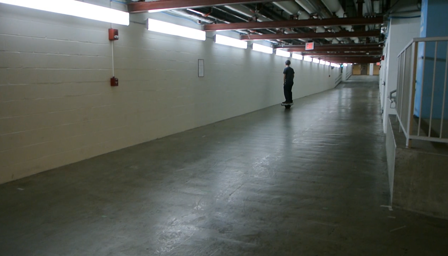

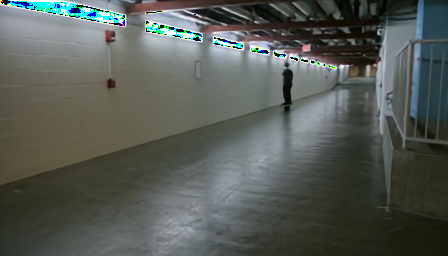

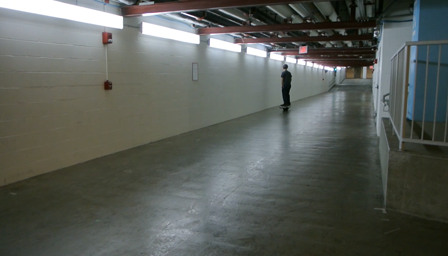

In [11]:
i = 0
for x in test_dataset:
    print(x[0].shape)
    print(x[0][0].shape)
    #split input back to separate images
    input_list = tf.split(x[0][0], 2, axis=2)
    model_input = tf.split(x[0], 16, axis=0)
    
    result = model.predict(model_input[0])
    
    display(tensor_to_image(input_list[0]))
    display(tensor_to_image(result[0]))
    display(tensor_to_image(input_list[1]))

    create_gif_from_tensors([input_list[0], result[0], input_list[1]], 'test' + str(i) + '.gif')
    
    #print(input_list[0].shape)
    #print(result[0].shape)
    #print(result[0])
    i+=1
    if i == 1:
        break

In [12]:
def create_input_object(start_image_tensor: tf.Tensor, end_image_tensor: tf.Tensor):
    concatted = tf.concat([start_image_tensor, end_image_tensor], axis=2)
    return tf.expand_dims(concatted, axis=0)

def create_intermediate_images(start_image_tensor: tf.Tensor, end_image_tensor: tf.Tensor, n: int):
    imageList = [start_image_tensor, end_image_tensor]
    for _ in range(n):
        newImageList = imageList.copy()
        for k in range(len(imageList) - 1):
            new_img = model.predict(create_input_object(imageList[k], imageList[k+1]))
            newImageList.insert(k + k + 1, new_img[0])
        imageList = newImageList
    return imageList

ITER = 5
i = 0
for batch in test_dataset:
    if i < 10:
        i+=1
        continue
    if i == 10:
        break
    first_triplets_in_batches = batch[0]
    #split input back to separate images
    input_images = tf.split(first_triplets_in_batches[0], 2, axis=2)

    output = create_intermediate_images(input_images[0], input_images[1], ITER)
    create_gif_from_tensors(output, 'slowmo_' + str(EPOCHS) + 'epochs_' + str(ITER) + 'iter_' + str(i) + '.gif')
    i+=1


### Use frames from custom video with bigger frame gap in between

In [13]:

def read_image_from_disk(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3, dtype=tf.uint8)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(scale= 1./255)(image)
    return image


GAP_START = 40
GAP_END = 41
ITER = 4
for i in range(GAP_START, GAP_END):
    imageStart = read_image_from_disk("./data/cat_walking/image-001.png")
    imageEnd = read_image_from_disk("./data/cat_walking/image-" + str(2+i).zfill(3) + ".png")

    output = create_intermediate_images(imageStart, imageEnd, ITER)
    create_gif_from_tensors(output, 'gap_' + str(i) + '_slowmo_' + str(EPOCHS) + 'epochs_' + str(ITER) + 'iter_' + str(i) + '.gif')
    i+=1